Victor CHAU & Tahar AMAIRI
# IFT 870 - Forage de données
## TP3 : Fonctions prédictives

### Sommaire

* 1. Implémentation de fonctions
    - a) ```model_score(class_model, X, y, params)```
    - b) ```bruteforce_optimisation(class_model, X, y, grille_param)```
    - c) ```randomize_optimisation(class_model, X, y, grille_param, sample_percent)```
    - d) ```halving_optimisation(class_model, X, y, grille_param, n_splitting)```
    - e) ```bayesian_optimisation(class_model, X, y, grille_param, s_size, n_iter)```
* 2. Comparaison de fonctions
    - a) Partitionnement en données d’entraînement et de test
    - b) Heatmaps
    - c) Réglage des hyperparamètres avec les différentes fonctions
    - d) Comparaison avec changement de partitionnement et de paramètres

## Importation des données

In [1]:
# import libs
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import randint

from skopt.space import Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from timeit import default_timer as timer
from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import warnings

# to mute skopt warnings
def warn(*args, **kwargs):
    pass

# mute
warnings.warn = warn

# set seed for numpy
np.random.seed(0)

In [2]:
# read CSV
data = pd.read_csv('TP3_data.csv', index_col=0)

# cast classe column to in
data['Classe'] = data['Classe'].astype(int)

# print the df
data.head()

,Attribut1,Attribut2,Attribut3,Attribut4,Classe
0,-7.662408,-5.851448,5.958728,7.846234,5
1,-5.287012,-10.373240,9.883442,8.947388,5
2,-8.048882,-5.600485,2.384850,-9.083051,8
3,-15.243415,-5.925116,-0.348595,-6.381597,8
4,3.693635,-7.545713,-0.465179,-1.017517,16


In [3]:
# split into X and y arrays
X = data.iloc[:,0:4].to_numpy()
y = data['Classe'].to_numpy()

## 1. Implémentation de fonctions
### a) ```model_score(class_model, X, y, params)```

In [4]:
def model_score(class_model, X, y, params):
    # split idx into 5 folds
    idxSplit = np.array_split(np.arange(0,X.shape[0]), 5)
    # to store the accuracy for each validation
    accList = list()
    # train mask
    idxTrain = np.ones(X.shape[0],dtype=bool)
    # set parameters
    class_model.set_params(**params)

    # loop over each test idx
    for idxTest in idxSplit:
        # set up mask
        idxTrain[idxTest] = 0
        # get train sets
        Xtrain, YTrain = X[idxTrain], y[idxTrain]
        # get test sets
        Xtest, YTest = X[idxTest], y[idxTest]
        # train model
        class_model.fit(Xtrain, YTrain)
        # get prediction score
        accList.append(class_model.score(Xtest, YTest))
        # reset mask
        idxTrain[:] = True

    # return mean accuracy
    return np.mean(accList)

### b) ```bruteforce_optimisation(class_model, X, y, grille_param)```

In [5]:
def bruteforce_optimisation(class_model, X, y, grille_param):
    # to store the best accuracy from the cv
    bestAcc = 0.0
    # same here but for the parameters of the model
    bestPara = None
    
    # get the grid search space
    keys = grille_param.keys() # get parameters
    combinations = itertools.product(*grille_param.values()) # get all the parameters combinations 
    grid = [dict(zip(keys, comb)) for comb in combinations] # zipped in list of dict 

    # grid search
    for params in grid:
        # get acc from cv
        acc = model_score(class_model, X, y, params)
        # update
        if acc > bestAcc:
            bestAcc = acc
            bestPara = params

    # return best parameters
    return bestAcc, bestPara

### c) ```randomize_optimisation(class_model, X, y, grille_param, sample_percent)```

In [6]:
def randomize_optimisation(class_model, X, y, grille_param, sample_percent):
    # check sample_percent value
    if sample_percent > 100 or sample_percent < 0:
        raise ValueError("sample_percent needs to in [0,100]")
    
    # to store the best accuracy from the cv
    bestAcc = 0.0
    # same here but for the parameters of the model
    bestPara = None

    # get the grid search space
    keys = grille_param.keys() # get parameters
    combinations = itertools.product(*grille_param.values()) # get all the parameters combinations 
    grid = [dict(zip(keys, comb)) for comb in combinations] # zipped in list of dict
    
    # shuffle
    np.random.shuffle(grid)
    # get a sample percent
    grid = grid[0:int(len(grid) * sample_percent / 100)]

    # grid search
    for params in grid:
        # get acc from cv
        acc = model_score(class_model, X, y, params)
        # update
        if acc > bestAcc:
            bestAcc = acc
            bestPara = params

    # return best parameters
    return bestAcc, bestPara

### d) ```halving_optimisation(class_model, X, y, grille_param, n_splitting)```

In [7]:
def halving_optimisation(class_model, X, y, grille_param, n_splitting):
    # get the grid search space
    keys = grille_param.keys() # get parameters
    combinations = itertools.product(*grille_param.values()) # get all the parameters combinations 
    grid = np.array([dict(zip(keys, comb)) for comb in combinations]) # zipped in list of dict

    # to store acc for each parameters
    accList = list()
    # size of the grid
    P = len(grid)
    # grid step
    step = int(P/n_splitting)
    # data size
    N = X.shape[0]
    # grid idx
    idx = range(0,P)

    # halving iter
    for i in range(1, n_splitting + 1):
        # get search & data space
        p = P - (step * (i - 1))  
        n = int(N * i / n_splitting)

        # get the corresponding data
        xn = X[0:n,:]
        yn = y[0:n]

        # get the best parameters
        grid = grid[idx[0:p]]
        
        # clear accuracy
        accList.clear()

        # grid search
        for params in grid:
        # append negative acc from cv (because of argsort)
           accList.append(- model_score(class_model, xn, yn, params))

        # get idx of sorted parameters based on the accuracy
        idx = np.argsort(accList)

    # get the best parameters
    grid = grid[idx]

    # return best parameters
    return - np.min(accList), grid[0]

### e) ```bayesian_optimisation(class_model, X, y, grille_param, s_size, n_iter)```

In [8]:
def bayesian_optimisation(class_model, X, y, grille_param, s_size, n_iter):
    # get the grid search space
    keys = grille_param.keys() # get parameters
    combinations = itertools.product(*grille_param.values()) # get all the parameters combinations 
    grid = np.array([dict(zip(keys, comb)) for comb in combinations]) # zipped in list of dict

    # transform the grid search space into a matrix
    M = np.array([list(params.values()) for params in grid])

    # set s_size accordingly to the number of parameters
    s_size = len(grid) if len(grid) < s_size else s_size

    # generate a sample of size s_size
    sampleIdx = np.random.choice(M.shape[0], s_size, replace=False)
    E = M[sampleIdx, :]

    # to cache the accuracy of sampled parameters
    accList = list()

    # get accuracy of the sampled parameters
    for params in E:
        # get acc from cv
        accList.append(model_score(class_model, X, y, dict(zip(keys, params))))

    # fit the approximation function
    GPR = GaussianProcessRegressor(random_state=0)
    GPR.fit(E, accList)

    # Bayesian search
    for _ in range(n_iter):
        # predict the scores of all parameters
        score = GPR.predict(M, return_std=True)

        # get the maximum mean from the predictions
        max_pred_moy = np.max(score[0])

        # generate a sample of size s_size
        sampleIdx = np.random.choice(M.shape[0], s_size, replace=False)
        sample = M[sampleIdx, :]

        # predict the scores of the sample
        scoreSample = GPR.predict(sample, return_std=True)

        # compute prob
        prob = (scoreSample[0] - max_pred_moy) / (scoreSample[1] + 10e-6)
        
        # get the parameter corresponding to the maximum proba
        max_param = sample[np.argmax(prob)]
        
        # add it to E
        E = np.vstack([E, max_param])

        # get the accuracy of the sampled parameter
        accList.append(model_score(class_model, X, y, dict(zip(keys, max_param))))

        # fit the approximation function
        GPR.fit(E, accList)

    # return best parameters
    return np.max(accList), dict(zip(keys, E[np.argmax(accList)]))

## 2. Comparaison de fonctions
### a) Partitionnement en données d’entraînement et de test

In [9]:
# use sklearn function to split into 70% train / 30% test set
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=0)

### b) Heatmaps

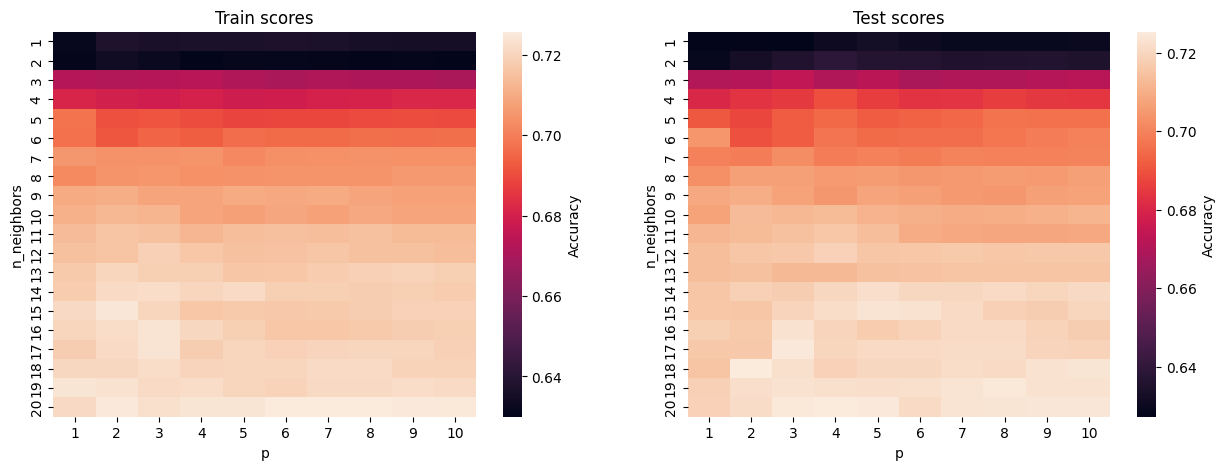

In [10]:
# parameters
class_model = KNeighborsClassifier(n_jobs=-1)
n_neighbors = range(1,21)
P = range(1,11)

# to store scores
trainScore, testScore = np.zeros((len(n_neighbors), len(P))), np.zeros((len(n_neighbors), len(P)))

# get all the scores
for i, n in enumerate(n_neighbors):
    for j, p in enumerate(P):
        # get train scores using cv
        trainScore[i,j] = model_score(class_model, XTrain, yTrain, {'n_neighbors': n, 'p': p})
        # get test scores
        testScore[i,j] = class_model.score(XTest, yTest)

# set subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# add titles
ax1.set_title('Train scores');
ax2.set_title('Test scores');

# plot heatmaps
heatMapTrain = sns.heatmap(trainScore, ax = ax1, cbar_kws={'label': 'Accuracy'});
heatMapTest = sns.heatmap(testScore, ax = ax2, cbar_kws={'label': 'Accuracy'});

# set labels and ticks
heatMapTrain.set(xlabel='p', ylabel='n_neighbors', xticklabels=list(P), yticklabels=list(n_neighbors));
heatMapTest.set(xlabel='p', ylabel='n_neighbors', xticklabels=list(P), yticklabels=list(n_neighbors));

# COMMENTAIRE : TODO (CHECK LE COURS)

### c) Réglage des hyperparamètres avec les différentes fonctions

In [11]:
# to benchmark the hand written functions
def benchmark(class_model, XTrain, yTrain, XTest, yTest, f, f_para):
    # get execution time, training accuracy and the best parameters
    start = timer()
    trainAcc, bestPara = f(class_model = class_model, X = XTrain, y = yTrain, **f_para)
    end = timer()

    # set best parameters
    class_model.set_params(**bestPara)

    # get test accuracy
    testAcc = class_model.score(XTest, yTest)

    # return the results as a list
    return [float("{:.2f}".format(end - start)), float("{:.5f}".format(trainAcc)), float("{:.5f}".format(testAcc))] + list(bestPara.values())

# to benchmark the sklearn functions
def benchmarkSklearn(class_model, XTrain, yTrain, XTest, yTest, f, f_para):
    # construct the class
    f = f(estimator = class_model, **f_para)

    # get execution time of the fit phase
    start = timer()
    f.fit(XTrain, yTrain)
    end = timer()

    # get train accuracy
    trainAcc = f.best_score_

    # get test accuracy
    testAcc = f.score(XTest, yTest)

    # get best parameters
    bestPara = f.best_params_

    # return the results as a list
    return [float("{:.2f}".format(end - start)), float("{:.5f}".format(trainAcc)), float("{:.5f}".format(testAcc))] + list(bestPara.values())

# to benchmark the skopt function
def benchmarkSkopt(class_model, XTrain, yTrain, XTest, yTest, f, f_para):
    # objective function "1 - accuracy"
    @use_named_args(f_para['dimensions'])
    def objective(**params):
        class_model.set_params(**params)
        return 1 - model_score(class_model, XTrain, yTrain, params)

    # get execution time of the fit phase
    start = timer()
    res = f(func = objective, **f_para)
    end = timer()

    # get best parameters
    bestPara = dict(zip(['n_neighbors','p'], res.x))

    # set best parameters
    class_model.set_params(**bestPara)

    # get train accuracy
    trainAcc = 1 - res.fun

    # get test accuracy
    testAcc = class_model.score(XTest, yTest)

    # return the results as a list
    return [float("{:.2f}".format(end - start)), float("{:.5f}".format(trainAcc)), float("{:.5f}".format(testAcc))] + list(bestPara.values())

In [12]:
# parameters
space = [Integer(1, 20, name='n_neighbors'), Integer(1, 10, name='p')]
grille_param = {'n_neighbors' : n_neighbors, 'p' : P}
grille_dist = {'n_neighbors' : randint(1, 21), 'p' : randint(1, 11)}
sample_percent = 30
n_splitting = 5
s_size = 5 
n_iter = 100

# to stock the results
perf = list()

# bruteforce_optimisation
res = benchmark(class_model, XTrain, yTrain, XTest, yTest, bruteforce_optimisation, {'grille_param' : grille_param})
perf.append(['bruteforce_optimisation'] + res)

# randomize_optimisation
res = benchmark(class_model, XTrain, yTrain, XTest, yTest, randomize_optimisation, {'grille_param' : grille_param, 'sample_percent' : sample_percent})
perf.append(['randomize_optimisation'] + res)

# halving_optimisation
res = benchmark(class_model, XTrain, yTrain, XTest, yTest, halving_optimisation, {'grille_param' : grille_param, 'n_splitting' : n_splitting})
perf.append(['halving_optimisation'] + res)

# bayesian_optimisation
res = benchmark(class_model, XTrain, yTrain, XTest, yTest, bayesian_optimisation, {'grille_param' : grille_param, 's_size' : s_size, 'n_iter' : n_iter})
perf.append(['bayesian_optimisation'] + res)

# GridSearchCV
res = benchmarkSklearn(class_model, XTrain, yTrain, XTest, yTest, GridSearchCV, {'param_grid' : grille_param, 'scoring' : 'accuracy'})
perf.append(['GridSearchCV'] + res)

# RandomizedSearchCV
res = benchmarkSklearn(class_model, XTrain, yTrain, XTest, yTest, RandomizedSearchCV, {'param_distributions' : grille_dist, 'scoring' : 'accuracy', 'n_iter' : 60, 'random_state' : 0})
perf.append(['RandomizedSearchCV'] + res)

# HalvingGridSearchCV
res = benchmarkSklearn(class_model, XTrain, yTrain, XTest, yTest, HalvingGridSearchCV, {'param_grid' : grille_param, 'scoring' : 'accuracy', 'factor' : 5, 'random_state' : 0})
perf.append(['HalvingGridSearchCV'] + res)

# gp_minimize
res = benchmarkSkopt(class_model, XTrain, yTrain, XTest, yTest, gp_minimize, {'dimensions' : space, 'random_state' : 0})
perf.append(['gp_minimize'] + res)

In [13]:
# display as data frame
dfPerf = pd.DataFrame(perf, columns=['Function', 'Execution time (s)', 'Train acc.', 'Test acc.'] + list(grille_param.keys()))
display(dfPerf)

,Function,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,bruteforce_optimisation,31.95,0.72571,0.72400,20,7
1,randomize_optimisation,9.44,0.72386,0.72333,19,1
2,halving_optimisation,54.16,0.72571,0.72367,20,7
3,bayesian_optimisation,17.35,0.72557,0.72100,20,6
4,GridSearchCV,33.24,0.72514,0.72333,20,6
5,RandomizedSearchCV,9.25,0.72514,0.72333,20,6
6,HalvingGridSearchCV,27.73,0.72240,0.71767,15,3
7,gp_minimize,50.54,0.72571,0.72400,20,7


# COMMENTAIRE : TODO

### d) Comparaison avec changement de partitionnement et de paramètres

In [14]:
# benchmark function with different parameters
def getBenchmarkDf(class_model, X, y, f, testSize, fBenchmark, fBenchmark_para, grid_param_name, grid_param):
    # get all the parameters combination for the function f 
    keys = fBenchmark_para.keys() # get parameters
    combinations = itertools.product(*fBenchmark_para.values()) # get all the parameters combinations 
    f_para = np.array([dict(zip(keys, comb)) for comb in combinations]) # zipped in list of dict

    # to store results for the plot after
    res = list()

    # benchmark all combinations
    for size in testSize:
        res.append(list())
        # split data
        XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=size, random_state=0)
        for para in f_para:
            # add grid parameters
            para[grid_param_name] = grid_param
            # get benchmark metrics
            metrics = fBenchmark(class_model, XTrain, yTrain, XTest, yTest, f, para)
            # delete the added key
            del para[grid_param_name]
            # store it
            res[-1].append(metrics)

    modelPara = list(grid_param.keys()) if type(grid_param) != list else [s.name for s in grid_param]
    # columns names
    col = ['Execution time (s)', 'Train acc.', 'Test acc.'] + modelPara
    # function para comb
    allComb = [str(para) for para in f_para]

    # display each df
    for i, m in enumerate(res):
        df = pd.DataFrame(m, columns=col)
        df.insert(0, 'Function parameters', allComb)
        print('Test size = {}'.format(testSize[i]))
        display(df)

In [15]:
# test sizes
testSize = [0.5, 0.7, 0.9]

In [16]:
# bruteforce_optimisation
getBenchmarkDf(class_model, X, y, bruteforce_optimisation, testSize, benchmark, {}, 'grille_param', grille_param)

Test size = 0.5


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{},23.19,0.7264,0.7214,16,2


Test size = 0.7


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{},15.51,0.72633,0.71614,18,6


Test size = 0.9


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{},8.74,0.727,0.70311,18,7


# COMMENTAIRE : TODO

In [17]:
# randomize_optimisation
benchmarkPara = {'sample_percent' : [20, 50, 80]}
getBenchmarkDf(class_model, X, y, randomize_optimisation, testSize, benchmark, benchmarkPara, 'grille_param', grille_param)

Test size = 0.5


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{'sample_percent': 20},4.56,0.7264,0.7214,16,2
1,{'sample_percent': 50},11.48,0.7264,0.7234,16,2
2,{'sample_percent': 80},18.42,0.7262,0.7236,18,2


Test size = 0.7


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{'sample_percent': 20},3.13,0.72500,0.71700,17,1
1,{'sample_percent': 50},7.88,0.72633,0.71614,18,6
2,{'sample_percent': 80},12.45,0.72633,0.71986,18,6


Test size = 0.9


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{'sample_percent': 20},1.75,0.726,0.70367,18,8
1,{'sample_percent': 50},4.42,0.726,0.70733,18,8
2,{'sample_percent': 80},7.03,0.727,0.70356,18,7


# COMMENTAIRE : TODO

In [18]:
# halving_optimisation
benchmarkPara = {'n_splitting' : [3, 6, 9]}
getBenchmarkDf(class_model, X, y, halving_optimisation, testSize, benchmark, benchmarkPara, 'grille_param', grille_param)

Test size = 0.5


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{'n_splitting': 3},30.43,0.7264,0.7224,16,2
1,{'n_splitting': 6},47.77,0.7260,0.7226,17,2
2,{'n_splitting': 9},64.38,0.7262,0.7218,18,2


Test size = 0.7


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{'n_splitting': 3},22.44,0.72633,0.71986,18,6
1,{'n_splitting': 6},35.25,0.72633,0.72057,18,6
2,{'n_splitting': 9},48.70,0.72633,0.71586,18,6


Test size = 0.9


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{'n_splitting': 3},14.96,0.727,0.70467,18,7
1,{'n_splitting': 6},24.96,0.714,0.70144,16,8
2,{'n_splitting': 9},35.13,0.725,0.70722,19,2


# COMMENTAIRE : TODO

In [19]:
# bayesian_optimisation
benchmarkPara = {'s_size' : [3, 6, 9], 'n_iter' : [75, 125, 175]}
getBenchmarkDf(class_model, X, y, bayesian_optimisation, testSize, benchmark, benchmarkPara, 'grille_param', grille_param)

Test size = 0.5


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,"{'s_size': 3, 'n_iter': 75}",9.01,0.7232,0.7160,15,2
1,"{'s_size': 3, 'n_iter': 125}",15.04,0.7262,0.7228,18,2
2,"{'s_size': 3, 'n_iter': 175}",20.71,0.7264,0.7236,16,2
3,"{'s_size': 6, 'n_iter': 75}",9.41,0.7262,0.7196,18,2
4,"{'s_size': 6, 'n_iter': 125}",15.12,0.7264,0.7274,16,2
5,"{'s_size': 6, 'n_iter': 175}",21.12,0.7264,0.7224,16,2
6,"{'s_size': 9, 'n_iter': 75}",9.78,0.7264,0.7246,16,2
7,"{'s_size': 9, 'n_iter': 125}",15.59,0.7264,0.7224,16,2
8,"{'s_size': 9, 'n_iter': 175}",21.55,0.7264,0.7224,16,2


Test size = 0.7


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,"{'s_size': 3, 'n_iter': 75}",6.17,0.72633,0.71986,18,6
1,"{'s_size': 3, 'n_iter': 125}",10.25,0.72600,0.71614,19,1
2,"{'s_size': 3, 'n_iter': 175}",14.28,0.72633,0.71757,18,6
3,"{'s_size': 6, 'n_iter': 75}",6.51,0.72633,0.71986,18,6
4,"{'s_size': 6, 'n_iter': 125}",10.51,0.72633,0.71943,18,6
5,"{'s_size': 6, 'n_iter': 175}",14.51,0.72633,0.71943,18,6
6,"{'s_size': 9, 'n_iter': 75}",6.72,0.72633,0.71557,18,6
7,"{'s_size': 9, 'n_iter': 125}",10.90,0.72633,0.71757,18,6
8,"{'s_size': 9, 'n_iter': 175}",14.78,0.72633,0.71943,18,6


Test size = 0.9


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,"{'s_size': 3, 'n_iter': 75}",3.53,0.727,0.70500,18,7
1,"{'s_size': 3, 'n_iter': 125}",5.87,0.727,0.70244,18,7
2,"{'s_size': 3, 'n_iter': 175}",8.42,0.727,0.70467,18,7
3,"{'s_size': 6, 'n_iter': 75}",3.71,0.722,0.70356,18,2
4,"{'s_size': 6, 'n_iter': 125}",6.12,0.727,0.70733,18,7
5,"{'s_size': 6, 'n_iter': 175}",8.33,0.727,0.70244,18,7
6,"{'s_size': 9, 'n_iter': 75}",3.82,0.725,0.70467,18,9
7,"{'s_size': 9, 'n_iter': 125}",6.15,0.727,0.70244,18,7
8,"{'s_size': 9, 'n_iter': 175}",8.53,0.727,0.70356,18,7


# COMMENTAIRE : TODO

In [20]:
# GridSearchCV
benchmarkPara = {'scoring' : ['accuracy']}
getBenchmarkDf(class_model, X, y, GridSearchCV, testSize, benchmarkSklearn, benchmarkPara, 'param_grid', grille_param)

Test size = 0.5


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{'scoring': 'accuracy'},25.05,0.7294,0.72,16,2


Test size = 0.7


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{'scoring': 'accuracy'},16.54,0.73,0.72214,20,8


Test size = 0.9


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{'scoring': 'accuracy'},10.8,0.728,0.71733,19,4


# COMMENTAIRE : TODO

In [21]:
# RandomizedSearchCV
benchmarkPara = {'scoring' : ['accuracy'], 'n_iter' : [40, 80, 120], 'random_state' : [0]}
getBenchmarkDf(class_model, X, y, RandomizedSearchCV, testSize, benchmarkSklearn, benchmarkPara, 'param_distributions', grille_dist)

Test size = 0.5


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,"{'scoring': 'accuracy', 'n_iter': 40, 'random_...",4.56,0.7254,0.7242,20,4
1,"{'scoring': 'accuracy', 'n_iter': 80, 'random_...",9.12,0.7258,0.7214,17,2
2,"{'scoring': 'accuracy', 'n_iter': 120, 'random...",13.77,0.7282,0.7196,20,2


Test size = 0.7


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,"{'scoring': 'accuracy', 'n_iter': 40, 'random_...",3.29,0.729,0.72171,20,6
1,"{'scoring': 'accuracy', 'n_iter': 80, 'random_...",6.61,0.729,0.72171,20,6
2,"{'scoring': 'accuracy', 'n_iter': 120, 'random...",9.99,0.729,0.72171,20,6


Test size = 0.9


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,"{'scoring': 'accuracy', 'n_iter': 40, 'random_...",2.14,0.728,0.71733,19,4
1,"{'scoring': 'accuracy', 'n_iter': 80, 'random_...",4.29,0.728,0.71733,19,4
2,"{'scoring': 'accuracy', 'n_iter': 120, 'random...",6.47,0.728,0.71733,19,4


# COMMENTAIRE : TODO

In [22]:
# HalvingGridSearchCV
benchmarkPara = {'scoring' : ['accuracy'], 'factor' : [3, 6, 9],'random_state' : [0]}
getBenchmarkDf(class_model, X, y, HalvingGridSearchCV, testSize, benchmarkSklearn, benchmarkPara, 'param_grid', grille_param)

Test size = 0.5


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,"{'scoring': 'accuracy', 'factor': 3, 'random_s...",30.34,0.70500,0.7174,11,1
1,"{'scoring': 'accuracy', 'factor': 6, 'random_s...",23.25,0.69667,0.7190,9,3
2,"{'scoring': 'accuracy', 'factor': 9, 'random_s...",22.55,0.70500,0.7174,11,1


Test size = 0.7


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,"{'scoring': 'accuracy', 'factor': 3, 'random_s...",30.33,0.71278,0.71943,14,10
1,"{'scoring': 'accuracy', 'factor': 6, 'random_s...",23.24,0.70167,0.71329,12,4
2,"{'scoring': 'accuracy', 'factor': 9, 'random_s...",22.49,0.71167,0.71871,14,6


Test size = 0.9


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,"{'scoring': 'accuracy', 'factor': 3, 'random_s...",25.62,0.71167,0.71289,16,2
1,"{'scoring': 'accuracy', 'factor': 6, 'random_s...",18.04,0.55500,0.67778,4,2
2,"{'scoring': 'accuracy', 'factor': 9, 'random_s...",17.92,0.55500,0.67778,4,2


# COMMENTAIRE : TODO 

In [23]:
# gp_minimize
benchmarkPara = {'random_state' : [0]}
getBenchmarkDf(class_model, X, y, gp_minimize, testSize, benchmarkSkopt, benchmarkPara, 'dimensions', space)

Test size = 0.5


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{'random_state': 0},41.17,0.724,0.7232,20,2


Test size = 0.7


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{'random_state': 0},41.36,0.726,0.71929,19,1


Test size = 0.9


,Function parameters,Execution time (s),Train acc.,Test acc.,n_neighbors,p
0,{'random_state': 0},38.43,0.726,0.70356,18,8


# COMMENTAIRE : TODO 

### Conclusion

# COMMENTAIRE : TODO 